In [1]:
import numpy as np
import pylab as pl
import datetime

#For the LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# To get the Mars orbit data from the JPL database
from astroquery.jplhorizons import Horizons
from astropy.time import Time

# First, get the Mars data for a 20 year window around 1600

In [7]:
# Query the Mars data for 20 years, in 7 day steps.
#
#      *This will take 15 minutes*

base = datetime.datetime(1600,1,2,20,0,0,0) # Start: 8pm on Jan 2nd 1600
dt = 7 # Get a datapoint every day

date_list = [base + datetime.timedelta(days=x) for x in range(0, 20*365, dt)]
tycho_data = np.zeros((len(date_list),5), dtype = np.float64)

for idx in range(len(date_list)):
    epoch = Time(date_list[idx])
    obj = Horizons('499', id_type='id', location='035', epochs=epoch.jd)
    # see JPL: '499' is the object id for Mars
    # see JPL: '035' is the observer code for Copenhagen ( 12°34'33.3''E, 55°41'12.7''N, 10.2 m )

    eph = obj.ephemerides()
    # eph contains a whole lot of data, like brightness, time of sunrise and set etc. Here we only look at
    # Azimuth, elevation (what Tycho B would have measured) + absolute time

    tycho_data[idx,0] = idx*dt     # time in days
    tycho_data[idx,1] = eph['AZ']  # azimuth in degre
    tycho_data[idx,2] = eph['EL']  # elevation in degree
    tycho_data[idx,3] = eph['DEC'] # declination in degree
    tycho_data[idx,4] = eph['RA']  # Right ascension in degrees

# Plot the Mars data

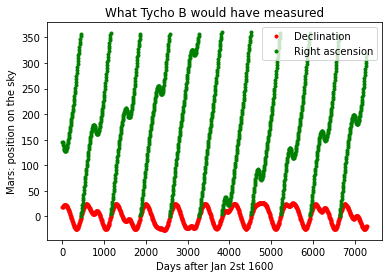

In [14]:
pl.title("What Tycho B would have measured")
pl.plot(tycho_data[:,0], tycho_data[:,3], 'r.', label = "Declination")
pl.plot(tycho_data[:,0], tycho_data[:,4], 'g.', label = "Right ascension")
pl.legend()
pl.xlabel("Days after Jan 2st 1600")
pl.ylabel("Mars: position on the sky");

# Fit a LSTM to the data

In [15]:
#Some housekeeping, and formatting
np.random.seed(7)
neurons = 50
batch_size = 1
X, y = tycho_data[:, 0:-1], tycho_data[:, 3] # Lets try declination
y = y/np.max(np.abs(y))                      # rescaled to -1|1
X = X.reshape(X.shape[0], 1, X.shape[1])

In [16]:
# Setting up LSTM
model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
# Doing the fit
model.fit(X, y, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1043/1043 - 1s - loss: 0.4270
Epoch 2/20
1043/1043 - 1s - loss: 0.3841
Epoch 3/20
1043/1043 - 1s - loss: 0.3107
Epoch 4/20
1043/1043 - 1s - loss: 0.3337
Epoch 5/20
1043/1043 - 1s - loss: 0.2007
Epoch 6/20
1043/1043 - 1s - loss: 0.1991
Epoch 7/20
1043/1043 - 1s - loss: 0.1389
Epoch 8/20
1043/1043 - 1s - loss: 0.2060
Epoch 9/20
1043/1043 - 1s - loss: 0.1462
Epoch 10/20
1043/1043 - 1s - loss: 0.1256
Epoch 11/20
1043/1043 - 1s - loss: 0.1272
Epoch 12/20
1043/1043 - 1s - loss: 0.1485
Epoch 13/20
1043/1043 - 1s - loss: 0.1104
Epoch 14/20
1043/1043 - 1s - loss: 0.1265
Epoch 15/20
1043/1043 - 1s - loss: 0.1097
Epoch 16/20
1043/1043 - 1s - loss: 0.1161
Epoch 17/20
1043/1043 - 1s - loss: 0.1055
Epoch 18/20
1043/1043 - 1s - loss: 0.1005
Epoch 19/20
1043/1043 - 1s - loss: 0.1010
Epoch 20/20
1043/1043 - 1s - loss: 0.1113


In [18]:
yhat = model.predict(X, batch_size=batch_size)

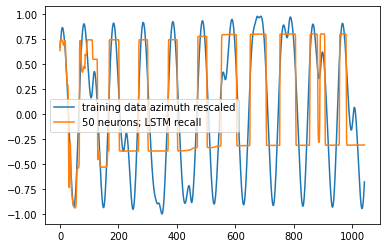

In [21]:
pl.plot(y, label='training data azimuth rescaled')
pl.plot(yhat, label='50 neurons; LSTM recall')
pl.legend()